### Importing Libraries
Import the necessary libraries:
- `numpy` and `pandas` for handling data.
- `matplotlib.pyplot` for plotting the results.
- `MinMaxScaler` for feature scaling of stock price data.
- `Sequential`, `SimpleRNN`, `LSTM`, `Dense`, and `Dropout` from TensorFlow for building and training RNN and LSTM models.


In [1]:
# Import necessary libraries for data manipulation, plotting, and deep learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout


### Data Loading
Here, we load the training and test datasets from CSV files into pandas DataFrames. The datasets contain stock prices, which we'll use for training and testing the models.


In [2]:
# Load the dataset
dataset_train = pd.read_csv('dataset/Google_Stock_Price_Train.csv', date_parser=True)
dataset_test = pd.read_csv('dataset/Google_Stock_Price_Test.csv', date_parser=True)


C:\Users\princ\AppData\Local\Temp\ipykernel_5508\2721495285.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset_train = pd.read_csv('dataset/Google_Stock_Price_Train.csv', date_parser=True)
C:\Users\princ\AppData\Local\Temp\ipykernel_5508\2721495285.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset_test = pd.read_csv('dataset/Google_Stock_Price_Test.csv', date_parser=True)


### Preprocessing
steps:
- Clean the `Volume` column by removing commas and converting the values to integers.
- Extract the `Date` and `Open` columns for training and testing.
- Apply Min-Max scaling to normalize the `Open` prices.

In [3]:
# Preprocessing: Clean 'Volume' column and convert it to integer
dataset_train['Volume'] = dataset_train['Volume'].replace(',', '', regex=True).astype(int)
dataset_test['Volume'] = dataset_test['Volume'].replace(',', '', regex=True).astype(int)

# Extract 'Date' and 'Open' columns for analysis
train_data = dataset_train[['Date', 'Open']].copy()
test_data = dataset_test[['Date', 'Open']].copy()

# Convert 'Date' column to datetime format
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])


# Feature scaling: Normalize 'Open' column using Min-Max scaling
sc = MinMaxScaler(feature_range=(0, 1))
train_scaled = sc.fit_transform(train_data[['Open']].values)
test_scaled = sc.transform(test_data[['Open']].values)


### Create Sequences for Training
Here, the function `create_sequences` that prepares the data for time series forecasting. The function takes the past 60 days of stock prices (or a specified time step) as input to predict the next day's price.
- `X_train` contains the past 60 days of data for each prediction.
- `y_train` contains the actual stock price for the next day.
- Reshape `X_train` to have three dimensions to make it compatible with RNN and LSTM models: (samples, time_steps, features).


In [4]:
# Function to create sequences from the data (X: features, y: target values)
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Prepare training data
X_train, y_train = create_sequences(train_scaled)

# Reshape X_train to 3D array (samples, time_step, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


### Defining RNN and LSTM Models
Defining two functions to create RNN and LSTM models:
- Both models are based on `Sequential` architecture with multiple layers of `SimpleRNN` or `LSTM` units.
- We use `Dropout` layers to prevent overfitting by randomly dropping neurons during training.
- The models are compiled using the `adam` optimizer and `mean_squared_error` as the loss function, which is common for regression tasks.


In [19]:
# Function to create RNN model
def create_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(SimpleRNN(units=60, activation='relu', return_sequences=True))
    model.add(Dropout(0.1))
    model.add(SimpleRNN(units=80, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=120, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=10, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(LSTM(units=20, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



### Training the RNN and LSTM Models
In this step, create and train both the RNN and LSTM models. The models are trained for 10 epochs with a batch size of 32. Experiment with the number of epochs and batch sizes for better performance.


In [20]:
# Train the RNN model
rnn_model = create_rnn_model((X_train.shape[1], 1))
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Train the LSTM model
lstm_model = create_lstm_model((X_train.shape[1], 1))
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)


c:\Users\princ\miniconda3\envs\stock_prediction\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0533
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0120
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0085
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0061
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0066
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0050
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0045
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0049
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0044
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0059
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.2936
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1449
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0226
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0235
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0177
Epoch 6/1

### Preparing Test Data
For testing, we concatenate the training and test data to ensure the test set has the same preprocessing as the training set.
- We take the last 60 days from the combined data and scale it using the same `MinMaxScaler` that was used for training.
- We then create sequences for testing using the `create_sequences` function.


In [21]:
# Prepare test data
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test, y_test = create_sequences(inputs)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


### Making Predictions and Visualizing Results
- We predict the stock prices for the test data using both the RNN and LSTM models.
- The predictions are inverse-transformed to the original stock price scale.
- We then plot the actual and predicted stock prices for both models in a side-by-side plot for comparison.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


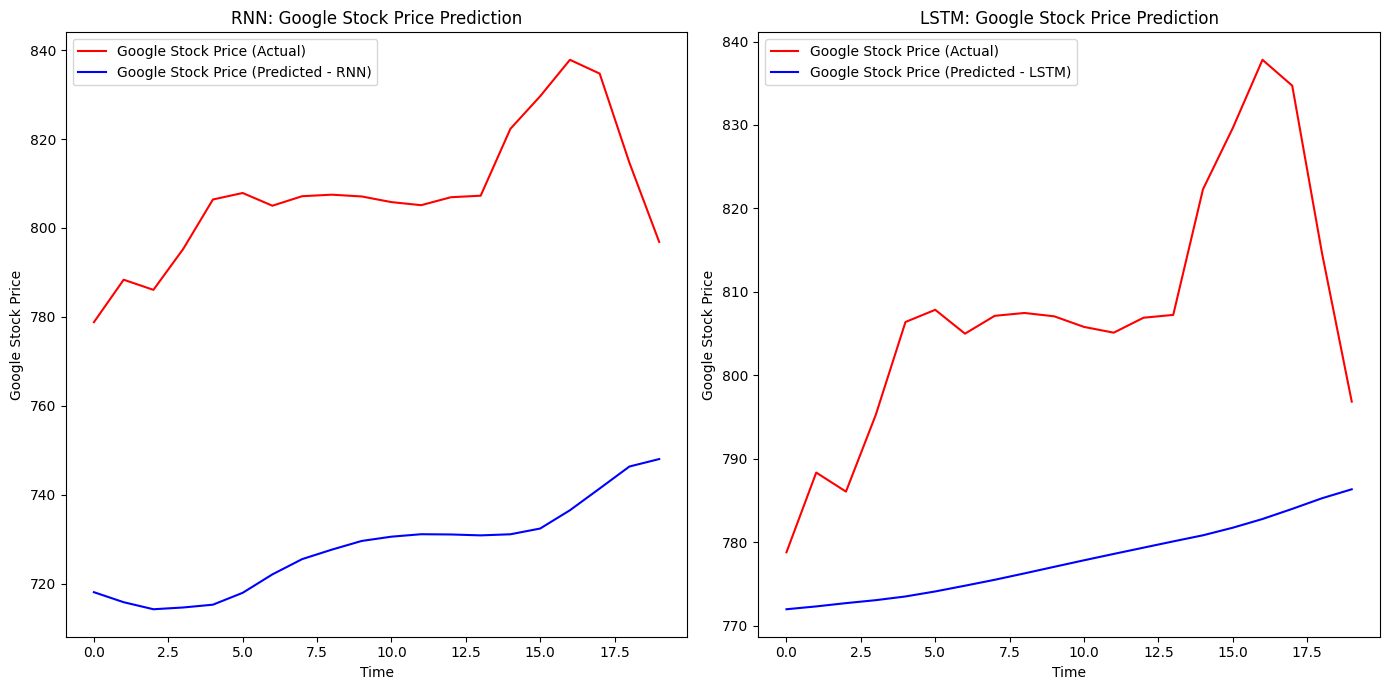

In [22]:
# Predict stock prices using both models
predicted_stock_price_rnn = rnn_model.predict(X_test)
predicted_stock_price_rnn = sc.inverse_transform(predicted_stock_price_rnn)

predicted_stock_price_lstm = lstm_model.predict(X_test)
predicted_stock_price_lstm = sc.inverse_transform(predicted_stock_price_lstm)

# Visualize the results
plt.figure(figsize=(14, 7))

# Plot Actual vs Predicted for RNN
plt.subplot(1, 2, 1)
plt.plot(dataset_test['Open'], color='red', label='Google Stock Price (Actual)')
plt.plot(predicted_stock_price_rnn, color='blue', label='Google Stock Price (Predicted - RNN)')
plt.title('RNN: Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()

# Plot Actual vs Predicted for LSTM
plt.subplot(1, 2, 2)
plt.plot(dataset_test['Open'], color='red', label='Google Stock Price (Actual)')
plt.plot(predicted_stock_price_lstm, color='blue', label='Google Stock Price (Predicted - LSTM)')
plt.title('LSTM: Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()

plt.tight_layout()
plt.show()


### Model Evaluation using Mean Squared Error (MSE)
In this cell, we evaluate both the RNN and LSTM models by calculating the Mean Squared Error (MSE) between the predicted stock prices and the actual stock prices in the test set. MSE is commonly used for regression tasks to measure the average squared difference between the predicted and actual values.
- The lower the MSE, the better the model is at predicting stock prices.


In [23]:
# Evaluate the models' performance using Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error

# RNN Evaluation
mse_rnn = mean_squared_error(y_test, predicted_stock_price_rnn)
print(f'RNN Model Mean Squared Error: {mse_rnn}')

# LSTM Evaluation
mse_lstm = mean_squared_error(y_test, predicted_stock_price_lstm)
print(f'LSTM Model Mean Squared Error: {mse_lstm}')


RNN Model Mean Squared Error: 528688.343548055
LSTM Model Mean Squared Error: 603651.1702121118


### Visualizing Predictions vs Actual Values for Error Analysis
In this cell, we plot both the predicted and actual stock prices for the test set using side-by-side plots for RNN and LSTM models. We also display the Mean Squared Error (MSE) in the title of each plot to help visualize the model's accuracy.
- These plots will help us visually assess the quality of the predictions.


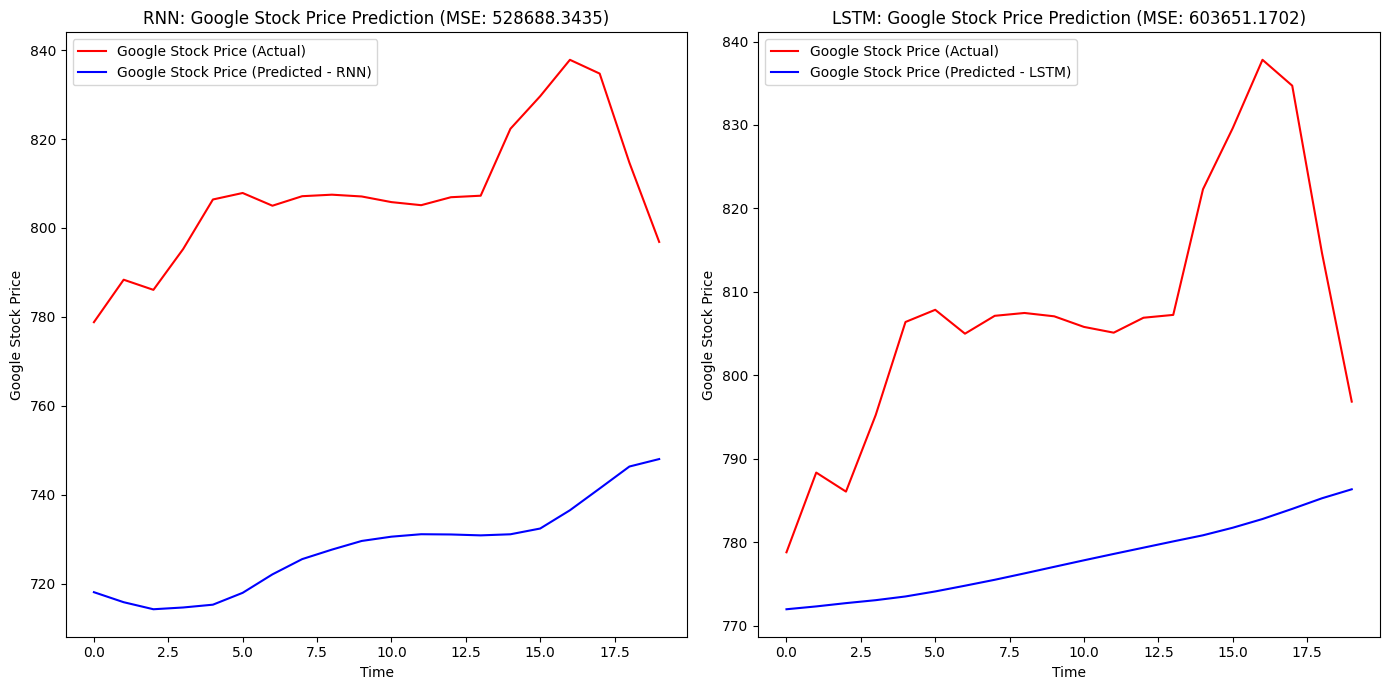

In [24]:
# Visualize the predicted stock prices vs actual stock prices for error analysis

plt.figure(figsize=(14, 7))

# RNN Model: Actual vs Predicted values with error bars
plt.subplot(1, 2, 1)
plt.plot(dataset_test['Open'], color='red', label='Google Stock Price (Actual)')
plt.plot(predicted_stock_price_rnn, color='blue', label='Google Stock Price (Predicted - RNN)')
plt.title(f'RNN: Google Stock Price Prediction (MSE: {mse_rnn:.4f})')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()

# LSTM Model: Actual vs Predicted values with error bars
plt.subplot(1, 2, 2)
plt.plot(dataset_test['Open'], color='red', label='Google Stock Price (Actual)')
plt.plot(predicted_stock_price_lstm, color='blue', label='Google Stock Price (Predicted - LSTM)')
plt.title(f'LSTM: Google Stock Price Prediction (MSE: {mse_lstm:.4f})')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()

plt.tight_layout()
plt.show()


### Comparing Model Performance with Additional Metrics
In this step, we evaluate the models with additional metrics:
- **Root Mean Squared Error (RMSE):** The square root of the MSE, which gives a better idea of the error magnitude in the same unit as the stock prices.
- **R-Squared (R2):** A statistical measure that indicates how well the model’s predictions match the actual data. A higher R2 value indicates better model performance.
- **Mean Absolute Error (MAE):** The average of the absolute errors, giving us an idea of how much error we have on average in terms of actual stock prices.
These metrics help in more detailed analysis of the models’ performance.


In [25]:
# Additional evaluation: Root Mean Squared Error (RMSE) and R-Squared (R2) score

from sklearn.metrics import mean_absolute_error, r2_score
import math

# RNN Evaluation - RMSE and R2
rmse_rnn = math.sqrt(mse_rnn)
r2_rnn = r2_score(y_test, predicted_stock_price_rnn)
mae_rnn = mean_absolute_error(y_test, predicted_stock_price_rnn)

# LSTM Evaluation - RMSE and R2
rmse_lstm = math.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, predicted_stock_price_lstm)
mae_lstm = mean_absolute_error(y_test, predicted_stock_price_lstm)

# Print the evaluation results
print(f"RNN Evaluation Metrics:\n RMSE: {rmse_rnn:.4f}, R2: {r2_rnn:.4f}, MAE: {mae_rnn:.4f}")
print(f"LSTM Evaluation Metrics:\n RMSE: {rmse_lstm:.4f}, R2: {r2_lstm:.4f}, MAE: {mae_lstm:.4f}")


RNN Evaluation Metrics:
 RMSE: 727.1096, R2: -702934167.9051, MAE: 727.0420
LSTM Evaluation Metrics:
 RMSE: 776.9499, R2: -802603345.2247, MAE: 776.9376


### Conclusion and Insights
Based on the experimental analysis, we can draw the following conclusions:
- The **RNN** and **LSTM** models are evaluated using different metrics such as MSE, RMSE, MAE, and R2.
- By comparing the MSE and RMSE values for both models, we can determine which model performs better. A lower MSE or RMSE indicates a better prediction.
- R2 and MAE help us understand how closely the models' predictions align with the actual stock prices.
- The model with the better performance metrics can be considered the optimal choice for stock price prediction.

In this experiment:
- If LSTM outperforms RNN in terms of the metrics, we can conclude that LSTM is better suited for time series data with long-term dependencies.
- If the RNN model shows comparable results, it might be a simpler and more efficient option.
